#Names
##1) Morad Khoury
##2) Ram Khoury

In this exercise we mainly used these two PDFS:

1)https://www.teach.cs.toronto.edu/~csc2542h/fall/material/csc2542f16_dqn.pdf
2)https://user.ceng.metu.edu.tr/~emre/resources/courses/AdvancedDL_Spring2017/DQN_Muhammed.pdf

we set the hyperparameters according to these PDFs,
and also in building the training function.
The idea behind our implementation of the training function was to save the policy network, target network and the graph of rewards every 1000 EPISODE.
So we wont to lose any information if the code or the session crashes, because it takes between 6-7 hours to train 35000 EPISODE.
At the end in the video part we load the networks and receive the video according to these trained networks.

# Deep Q-Network for Atari Breakout.

In this assignment you are required to implement a Deep Q-Network agent, for the Atari game Breakout.

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent.


__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [ ]:
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install stable-baselines3[extra] ale-py==0.7.4 gym==0.21.0
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay

  Using cached stable_baselines3-2.2.1-py3-none-any.whl (181 kB)
  Using cached ale_py-0.7.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Using cached gym-0.21.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
INFO: pip is looking at multiple versions of shimmy[atari] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 6.0 MB/s eta 0

In [ ]:
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfonts-encodings.
Preparing to unpack .../4-xfonts-encodings_1%3a1.0.5-0ubuntu2_all.deb ...
Unpacking xfonts-encodings (1:1.0.5-0ubuntu2) ...
Selecting previously unselected package xfonts-util

In [ ]:
# device config
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print('device: ', device)

device:  cuda


## Breakout

This is an environment emulating the Atari game *Breakout*. The goal is to break all the bricks in the wall without letting the ball touch the floor. You have 5 lives and get points more points for higher brick than for the lower ones.

The observation is an image with dimensions (210, 160, 3).

There are 4 actions defined as NOOP, FIRE, LEFT and RIGHT.

See full description [here](https://www.gymlibrary.dev/environments/atari/breakout/).




observation dim (210, 160, 3) number of actions 4


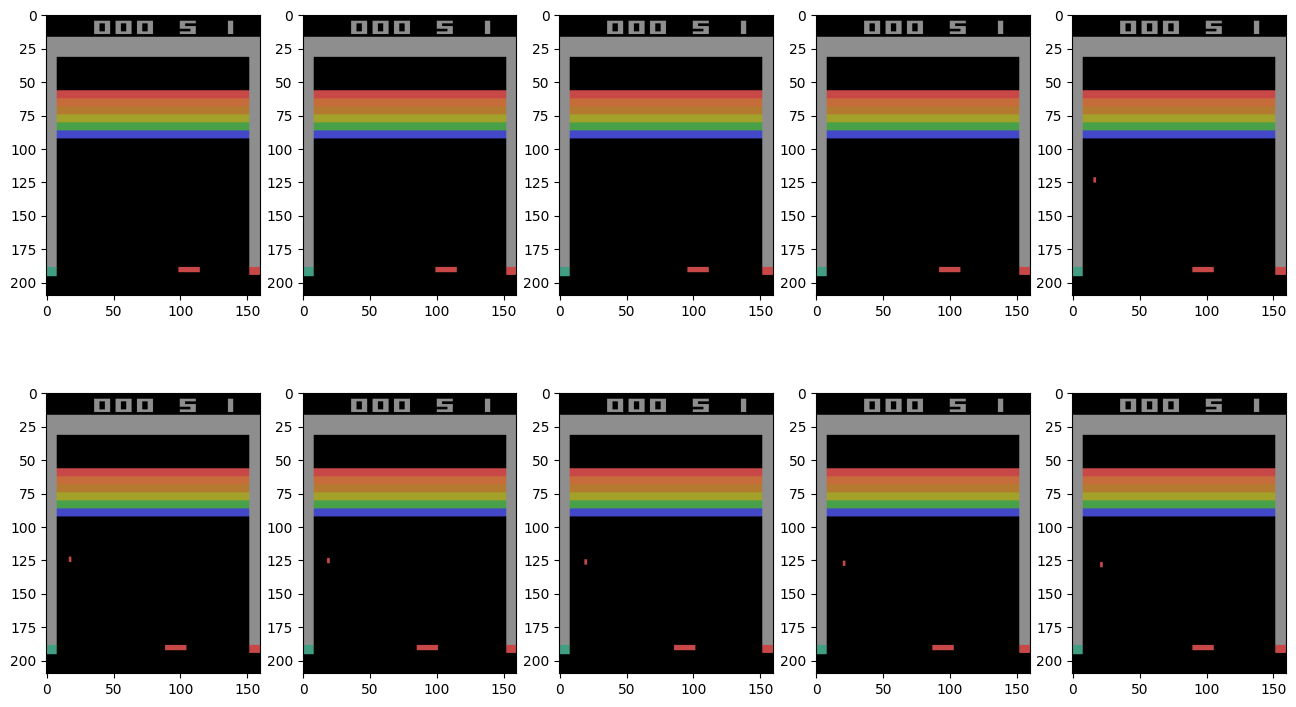

In [ ]:
ENV_NAME = "BreakoutNoFrameskip-v4"
env = gym.make(ENV_NAME)
obs = env.reset()

n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)


n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        #ax.imshow(obs)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Wrappers

In order to make the environment more suitable for RL training, we make the following updates to the environment, using environment wrappers:
1. Preprocess the images to contain only the relevant part of the image, converted to grayscale. The raw images are large and we can do with 64x64 images.
2. Concatenate the 4 previous images (in order to capture dynamics)
3. Start the fire action automatically when starting the episode
4. Repeat the same action for 4 time steps
5. Output the maximum values of the last 2 frames per pixel (in order to prevent blinking)
6. Ouput a "done" signal every time a life is reduced but only reset the environment when all lives are gone
7. Bin the rewards to the values {-1, 0, 1}




In [ ]:
from gym.core import Wrapper
from gym.spaces.box import Box
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 84, 84)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def observation(self, img):
        """what happens to each observation"""

        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img = img[34:-16, 8:-8, :]
        img = cv2.resize(img, self.img_size[1:])
        img = (img*np.array([[[0.8, .1, .1]]])).sum(-1, keepdims=True)  # grayscale with more weight for red (accelerates training)
        img = img.astype('float32') / 255.
        return img.transpose((2, 0, 1))

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = ClipRewardEnv(env)

    # This wrapper preprocesses observations
    env = PreprocessAtariObs(env)
    return env

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)


def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

## Check observations under wrappers

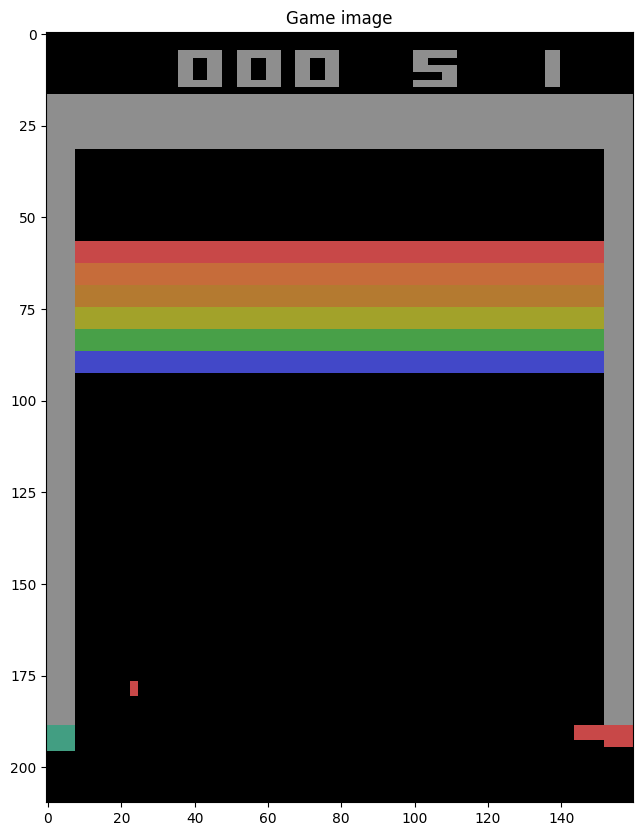

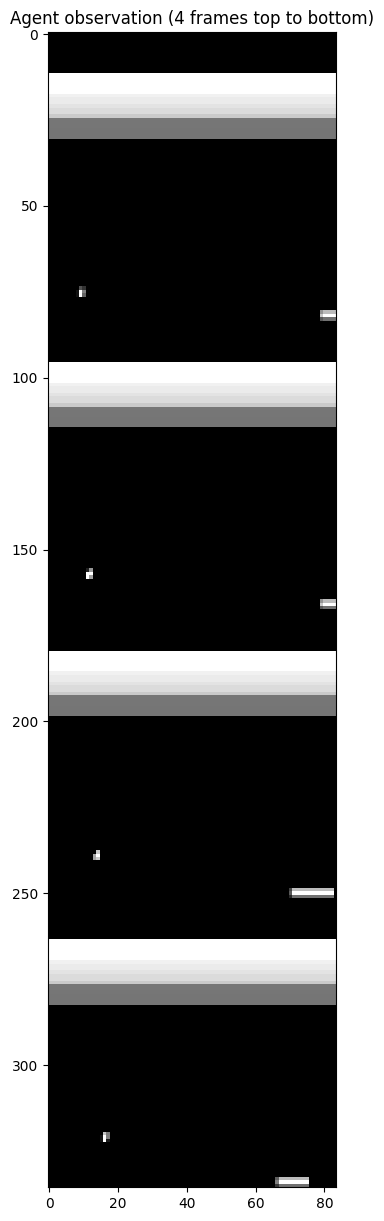

In [ ]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.reshape([-1, state_shape[2]]), cmap='gray')
plt.show()

## Random Agent

Here we implement a random agent to use in the 'evaluate' function, that runs the agent through multiple epsiodes.

In [ ]:
class RandomAgent():
    def __init__(self, n_actions):
        self.n_actions = n_actions


    def get_qvalues(self, states):
        return np.random.normal(size=(1,self.n_actions,))

    def sample_actions(self, qvalues):
        return np.random.randint(self.n_actions, size=(1,))

In [ ]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
              break

        rewards.append(reward)
    return np.mean(rewards)

agent = RandomAgent(n_actions)
mean_reward = evaluate(env, agent, greedy=True, n_games=5)

## Video generation

In [ ]:
# run sessions

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

n_games = 1 # how many games to record

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate(env_monitor, agent, n_games=3, greedy=False) for _ in range(10)]


In [ ]:
# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

## Assignment

Implement a DQN agent that contains:
1. A neural network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple, deque
import torch.nn.functional as F
import random
from collections import namedtuple
import numpy as np
import gym
from IPython.display import clear_output


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Replay Buffer and DQN Network classes

In [ ]:
class DQN_Network(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN_Network, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(self._get_conv_output(input_shape), 512)
        self.fc2 = nn.Linear(512, n_actions)

    def _get_conv_output(self, shape):
        output = self.conv1(torch.zeros(1, *shape))
        output = self.conv2(output)
        output = self.conv3(output)
        return int(np.prod(output.size()))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        return self.fc2(x)

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)

#DQN Agent Class
##   The hyperparameters were chosen from these links of pdfs:
###1)https://www.teach.cs.toronto.edu/~csc2542h/fall/material/csc2542f16_dqn.pdf
###2)https://user.ceng.metu.edu.tr/~emre/resources/courses/AdvancedDL_Spring2017/DQN_Muhammed.pdf

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
GAMMA = 0.99
EPSILON = 1.0
EPSILON_MIN = 0.1
EPSILON_DECAY = 0.9 / 1000000
TARGET_UPDATE = 10000
MEMORY_SIZE = 10000
learning_rate = 0.00025

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQNAgent:
    def __init__(self, input_shape, n_actions):
        self.policy_net = DQN_Network(input_shape, n_actions).to(device)
        self.target_net = DQN_Network(input_shape, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr = learning_rate)
        self.criterion = F.smooth_l1_loss
        self.memory = ReplayBuffer(MEMORY_SIZE)

        self.steps_done = 0
        self.n_actions = n_actions
        self.input_shape = input_shape
        self.epsilon = EPSILON
        self.epsilon_min = EPSILON_MIN
        self.gamma = GAMMA
        self.episode_rewards = []
        self.average_rewards = 0

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            q_values = self.policy_net(state.unsqueeze(0)).to(device)
            return q_values.max(1)[1].view(1, 1).item()
    def store_transition(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        state, action, reward, next_state, done = self.memory.sample(BATCH_SIZE)

        states_sample = torch.FloatTensor(state).to(device)
        actions_sample = torch.LongTensor(action).to(device)
        rewards_sample = torch.FloatTensor(reward).unsqueeze(1).to(device)
        next_states_sample = torch.FloatTensor(next_state).to(device)
        dones_sample = torch.FloatTensor(done).unsqueeze(1).to(device)

        current_q_values = self.policy_net(states_sample).gather(1, actions_sample.unsqueeze(1))
        next_q_values = self.target_net(next_states_sample).max(1)[0].unsqueeze(1)
        target_q_values = rewards_sample + (1 - dones_sample) * self.gamma * next_q_values

        loss = self.criterion(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())



#Train function

Episode 0: Total Reward: 0.0, Epsilon: 0.9999793000000007, frames_done: 23
Episode 10: Total Reward: 2.0, Epsilon: 0.9996013000000131, frames_done: 443
Episode 20: Total Reward: 0.0, Epsilon: 0.9993295000000221, frames_done: 745
Episode 30: Total Reward: 0.0, Epsilon: 0.9991225000000289, frames_done: 975
Episode 40: Total Reward: 0.0, Epsilon: 0.9989155000000357, frames_done: 1205
Episode 50: Total Reward: 0.0, Epsilon: 0.9985393000000481, frames_done: 1623
Episode 60: Total Reward: 0.0, Epsilon: 0.998270200000057, frames_done: 1922
Episode 70: Total Reward: 0.0, Epsilon: 0.997903900000069, frames_done: 2329
Episode 80: Total Reward: 0.0, Epsilon: 0.9977005000000757, frames_done: 2555
Episode 90: Total Reward: 0.0, Epsilon: 0.9974143000000851, frames_done: 2873
Episode 100: Total Reward: 0.0, Epsilon: 0.9971416000000941, frames_done: 3176
Episode 110: Total Reward: 1.0, Epsilon: 0.9967861000001058, frames_done: 3571
Episode 120: Total Reward: 0.0, Epsilon: 0.9965134000001148, frames_do

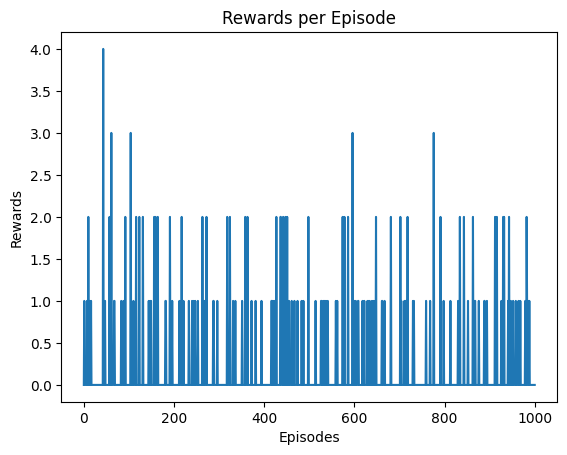

Episode 1010: Total Reward: 0.0, Epsilon: 0.9725077000009051, frames_done: 30547
Episode 1020: Total Reward: 0.0, Epsilon: 0.9722152000009148, frames_done: 30872
Episode 1030: Total Reward: 0.0, Epsilon: 0.9720082000009216, frames_done: 31102
Episode 1040: Total Reward: 0.0, Epsilon: 0.9717760000009292, frames_done: 31360
Episode 1050: Total Reward: 0.0, Epsilon: 0.9714907000009386, frames_done: 31677
Episode 1060: Total Reward: 0.0, Epsilon: 0.9712180000009476, frames_done: 31980
Episode 1070: Total Reward: 0.0, Epsilon: 0.9709750000009556, frames_done: 32250
Episode 1080: Total Reward: 0.0, Epsilon: 0.9707041000009645, frames_done: 32551
Episode 1090: Total Reward: 2.0, Epsilon: 0.9702784000009785, frames_done: 33024
Episode 1100: Total Reward: 0.0, Epsilon: 0.969958900000989, frames_done: 33379
Episode 1110: Total Reward: 0.0, Epsilon: 0.9696889000009979, frames_done: 33679
Episode 1120: Total Reward: 0.0, Epsilon: 0.9694000000010075, frames_done: 34000
Episode 1130: Total Reward: 0

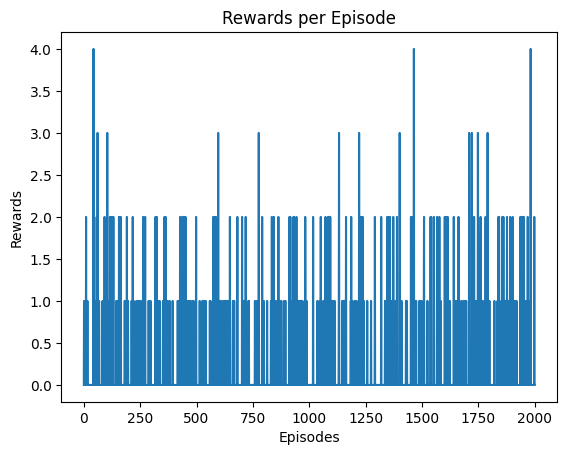

Episode 2010: Total Reward: 0.0, Epsilon: 0.9443836000018311, frames_done: 61796
Episode 2020: Total Reward: 0.0, Epsilon: 0.94411270000184, frames_done: 62097
Episode 2030: Total Reward: 0.0, Epsilon: 0.9437572000018517, frames_done: 62492
Episode 2040: Total Reward: 0.0, Epsilon: 0.9435520000018585, frames_done: 62720
Episode 2050: Total Reward: 0.0, Epsilon: 0.9432802000018674, frames_done: 63022
Episode 2060: Total Reward: 0.0, Epsilon: 0.9430768000018741, frames_done: 63248
Episode 2070: Total Reward: 0.0, Epsilon: 0.9428041000018831, frames_done: 63551
Episode 2080: Total Reward: 0.0, Epsilon: 0.9425593000018911, frames_done: 63823
Episode 2090: Total Reward: 0.0, Epsilon: 0.9422236000019022, frames_done: 64196
Episode 2100: Total Reward: 0.0, Epsilon: 0.9418906000019132, frames_done: 64566
Episode 2110: Total Reward: 1.0, Epsilon: 0.9415522000019243, frames_done: 64942
Episode 2120: Total Reward: 0.0, Epsilon: 0.941106700001939, frames_done: 65437
Episode 2130: Total Reward: 0.0

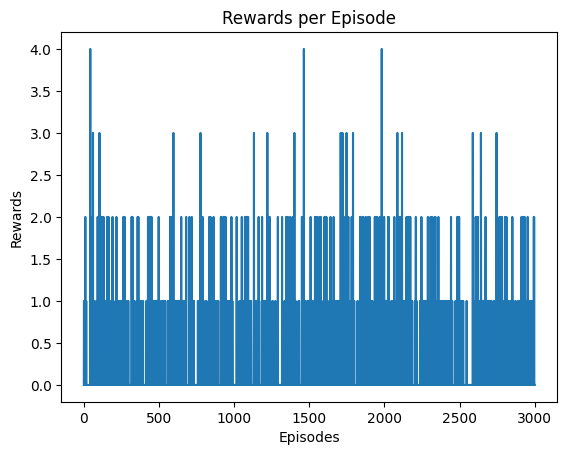

Episode 3010: Total Reward: 0.0, Epsilon: 0.9166015000027458, frames_done: 92665
Episode 3020: Total Reward: 0.0, Epsilon: 0.9162046000027588, frames_done: 93106
Episode 3030: Total Reward: 0.0, Epsilon: 0.9159319000027678, frames_done: 93409
Episode 3040: Total Reward: 0.0, Epsilon: 0.9156628000027767, frames_done: 93708
Episode 3050: Total Reward: 0.0, Epsilon: 0.9151498000027936, frames_done: 94278
Episode 3060: Total Reward: 2.0, Epsilon: 0.9146233000028109, frames_done: 94863
Episode 3070: Total Reward: 0.0, Epsilon: 0.9144199000028176, frames_done: 95089
Episode 3080: Total Reward: 0.0, Epsilon: 0.9141751000028256, frames_done: 95361
Episode 3090: Total Reward: 0.0, Epsilon: 0.9139699000028324, frames_done: 95589
Episode 3100: Total Reward: 0.0, Epsilon: 0.9137413000028399, frames_done: 95843
Episode 3110: Total Reward: 2.0, Epsilon: 0.9133678000028522, frames_done: 96258
Episode 3120: Total Reward: 0.0, Epsilon: 0.9129898000028647, frames_done: 96678
Episode 3130: Total Reward: 

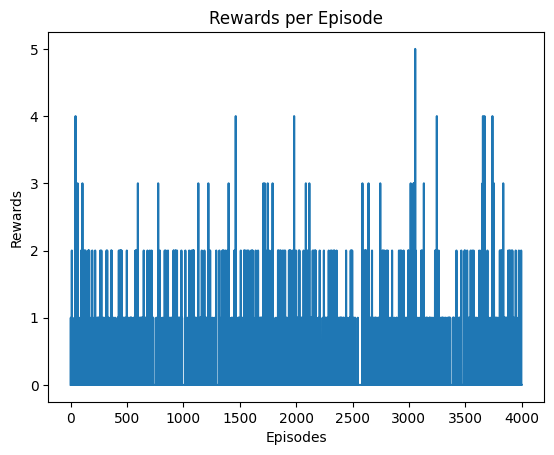

Episode 4010: Total Reward: 0.0, Epsilon: 0.8884153000036737, frames_done: 123983
Episode 4020: Total Reward: 0.0, Epsilon: 0.8881444000036827, frames_done: 124284
Episode 4030: Total Reward: 0.0, Epsilon: 0.8878996000036907, frames_done: 124556
Episode 4040: Total Reward: 0.0, Epsilon: 0.8876674000036984, frames_done: 124814
Episode 4050: Total Reward: 0.0, Epsilon: 0.8874604000037052, frames_done: 125044
Episode 4060: Total Reward: 0.0, Epsilon: 0.8871733000037146, frames_done: 125363
Episode 4070: Total Reward: 0.0, Epsilon: 0.8868349000037258, frames_done: 125739
Episode 4080: Total Reward: 0.0, Epsilon: 0.8864758000037376, frames_done: 126138
Episode 4090: Total Reward: 0.0, Epsilon: 0.8862742000037442, frames_done: 126362
Episode 4100: Total Reward: 0.0, Epsilon: 0.8859997000037533, frames_done: 126667
Episode 4110: Total Reward: 0.0, Epsilon: 0.8857981000037599, frames_done: 126891
Episode 4120: Total Reward: 0.0, Epsilon: 0.885551500003768, frames_done: 127165
Episode 4130: Tot

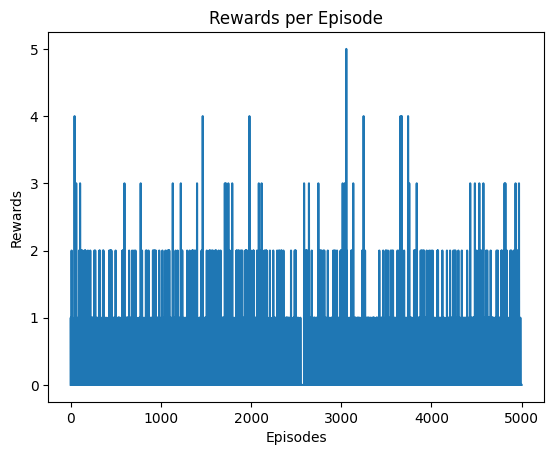

Episode 5010: Total Reward: 0.0, Epsilon: 0.8608564000045811, frames_done: 154604
Episode 5020: Total Reward: 0.0, Epsilon: 0.86058640000459, frames_done: 154904
Episode 5030: Total Reward: 0.0, Epsilon: 0.8603812000045967, frames_done: 155132
Episode 5040: Total Reward: 0.0, Epsilon: 0.8601778000046034, frames_done: 155358
Episode 5050: Total Reward: 0.0, Epsilon: 0.8597989000046159, frames_done: 155779
Episode 5060: Total Reward: 0.0, Epsilon: 0.8594425000046276, frames_done: 156175
Episode 5070: Total Reward: 0.0, Epsilon: 0.8591725000046365, frames_done: 156475
Episode 5080: Total Reward: 0.0, Epsilon: 0.8588872000046459, frames_done: 156792
Episode 5090: Total Reward: 0.0, Epsilon: 0.8586046000046552, frames_done: 157106
Episode 5100: Total Reward: 0.0, Epsilon: 0.858397600004662, frames_done: 157336
Episode 5110: Total Reward: 0.0, Epsilon: 0.858126700004671, frames_done: 157637
Episode 5120: Total Reward: 0.0, Epsilon: 0.857882800004679, frames_done: 157908
Episode 5130: Total R

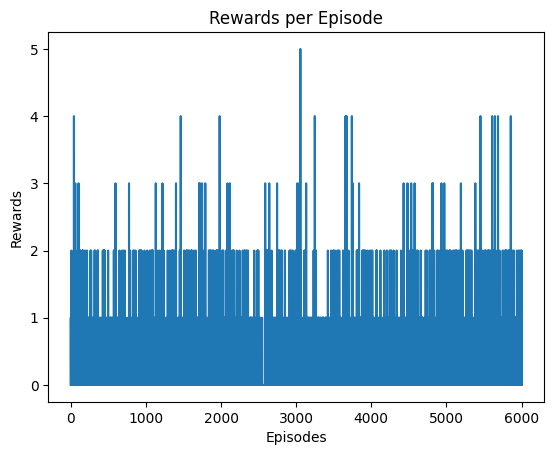

Episode 6010: Total Reward: 0.0, Epsilon: 0.8309269000055665, frames_done: 187859
Episode 6020: Total Reward: 0.0, Epsilon: 0.8306290000055763, frames_done: 188190
Episode 6030: Total Reward: 0.0, Epsilon: 0.8303824000055844, frames_done: 188464
Episode 6040: Total Reward: 0.0, Epsilon: 0.8300926000055939, frames_done: 188786
Episode 6050: Total Reward: 0.0, Epsilon: 0.8297164000056063, frames_done: 189204
Episode 6060: Total Reward: 0.0, Epsilon: 0.8294590000056148, frames_done: 189490
Episode 6070: Total Reward: 0.0, Epsilon: 0.8291449000056251, frames_done: 189839
Episode 6080: Total Reward: 0.0, Epsilon: 0.8288335000056354, frames_done: 190185
Episode 6090: Total Reward: 0.0, Epsilon: 0.8285617000056443, frames_done: 190487
Episode 6100: Total Reward: 0.0, Epsilon: 0.8282737000056538, frames_done: 190807
Episode 6110: Total Reward: 0.0, Epsilon: 0.8279614000056641, frames_done: 191154
Episode 6120: Total Reward: 0.0, Epsilon: 0.8275519000056776, frames_done: 191609
Episode 6130: To

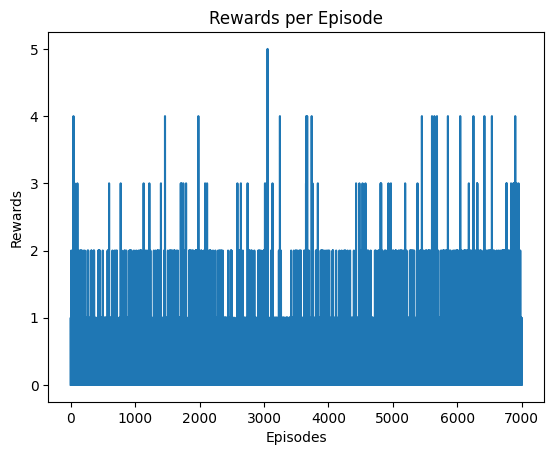

Episode 7010: Total Reward: 0.0, Epsilon: 0.7989616000066189, frames_done: 223376
Episode 7020: Total Reward: 0.0, Epsilon: 0.7985107000066337, frames_done: 223877
Episode 7030: Total Reward: 0.0, Epsilon: 0.7982803000066413, frames_done: 224133
Episode 7040: Total Reward: 0.0, Epsilon: 0.7977817000066577, frames_done: 224687
Episode 7050: Total Reward: 0.0, Epsilon: 0.7974496000066686, frames_done: 225056
Episode 7060: Total Reward: 0.0, Epsilon: 0.7970977000066802, frames_done: 225447
Episode 7070: Total Reward: 0.0, Epsilon: 0.7968052000066899, frames_done: 225772
Episode 7080: Total Reward: 0.0, Epsilon: 0.796467700006701, frames_done: 226147
Episode 7090: Total Reward: 0.0, Epsilon: 0.7961284000067121, frames_done: 226524
Episode 7100: Total Reward: 0.0, Epsilon: 0.7958458000067214, frames_done: 226838
Episode 7110: Total Reward: 0.0, Epsilon: 0.795615400006729, frames_done: 227094
Episode 7120: Total Reward: 0.0, Epsilon: 0.7952761000067402, frames_done: 227471
Episode 7130: Tota

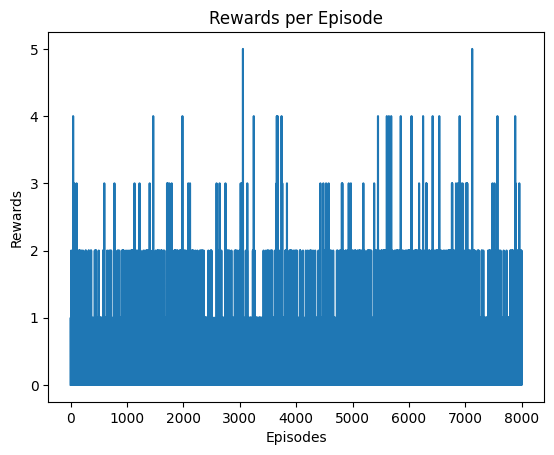

Episode 8010: Total Reward: 0.0, Epsilon: 0.7673491000076597, frames_done: 258501
Episode 8020: Total Reward: 0.0, Epsilon: 0.7670386000076699, frames_done: 258846
Episode 8030: Total Reward: 0.0, Epsilon: 0.7665292000076867, frames_done: 259412
Episode 8040: Total Reward: 0.0, Epsilon: 0.7662988000076942, frames_done: 259668
Episode 8050: Total Reward: 0.0, Epsilon: 0.7660162000077035, frames_done: 259982
Episode 8060: Total Reward: 0.0, Epsilon: 0.7656949000077141, frames_done: 260339
Episode 8070: Total Reward: 0.0, Epsilon: 0.7653448000077256, frames_done: 260728
Episode 8080: Total Reward: 0.0, Epsilon: 0.7650892000077341, frames_done: 261012
Episode 8090: Total Reward: 0.0, Epsilon: 0.7648426000077422, frames_done: 261286
Episode 8100: Total Reward: 0.0, Epsilon: 0.7646374000077489, frames_done: 261514
Episode 8110: Total Reward: 0.0, Epsilon: 0.7641019000077666, frames_done: 262109
Episode 8120: Total Reward: 0.0, Epsilon: 0.7637347000077787, frames_done: 262517
Episode 8130: To

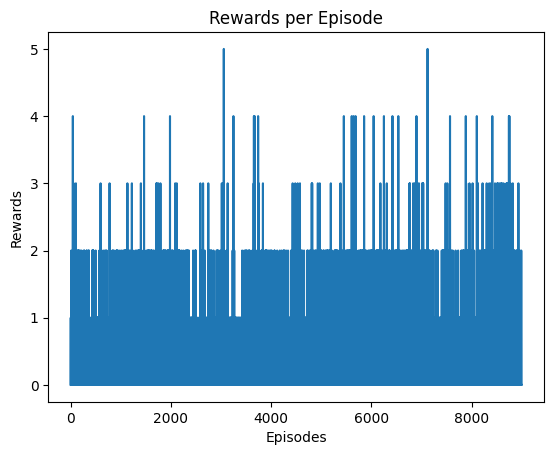

Episode 9010: Total Reward: 1.0, Epsilon: 0.7325839000088042, frames_done: 297129
Episode 9020: Total Reward: 0.0, Epsilon: 0.7323823000088109, frames_done: 297353
Episode 9030: Total Reward: 0.0, Epsilon: 0.7320115000088231, frames_done: 297765
Episode 9040: Total Reward: 0.0, Epsilon: 0.7317136000088329, frames_done: 298096
Episode 9050: Total Reward: 0.0, Epsilon: 0.7313347000088454, frames_done: 298517
Episode 9060: Total Reward: 0.0, Epsilon: 0.7310836000088536, frames_done: 298796
Episode 9070: Total Reward: 0.0, Epsilon: 0.7307245000088655, frames_done: 299195
Episode 9080: Total Reward: 0.0, Epsilon: 0.7303960000088763, frames_done: 299560
Episode 9090: Total Reward: 0.0, Epsilon: 0.7301071000088858, frames_done: 299881
Episode 9100: Total Reward: 0.0, Epsilon: 0.7297255000088984, frames_done: 300305
Episode 9110: Total Reward: 0.0, Epsilon: 0.7293070000089121, frames_done: 300770
Episode 9120: Total Reward: 0.0, Epsilon: 0.7290343000089211, frames_done: 301073
Episode 9130: To

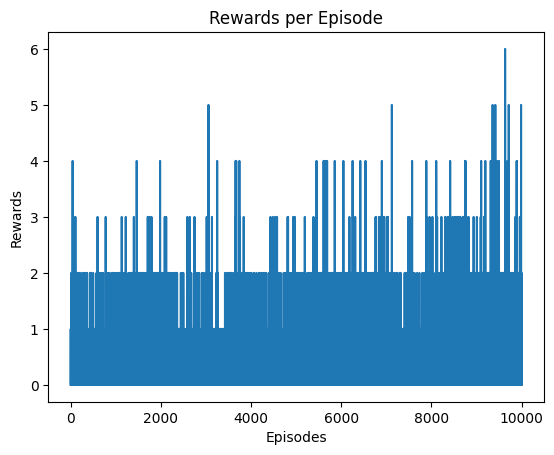

Episode 10010: Total Reward: 0.0, Epsilon: 0.6984469000099282, frames_done: 335059
Episode 10020: Total Reward: 0.0, Epsilon: 0.6981913000099366, frames_done: 335343
Episode 10030: Total Reward: 0.0, Epsilon: 0.6978385000099482, frames_done: 335735
Episode 10040: Total Reward: 0.0, Epsilon: 0.6974938000099595, frames_done: 336118
Episode 10050: Total Reward: 0.0, Epsilon: 0.6969808000099764, frames_done: 336688
Episode 10060: Total Reward: 0.0, Epsilon: 0.696538900009991, frames_done: 337179
Episode 10070: Total Reward: 0.0, Epsilon: 0.6958495000100137, frames_done: 337945
Episode 10080: Total Reward: 0.0, Epsilon: 0.6954193000100278, frames_done: 338423
Episode 10090: Total Reward: 0.0, Epsilon: 0.6951655000100362, frames_done: 338705
Episode 10100: Total Reward: 0.0, Epsilon: 0.6948946000100451, frames_done: 339006
Episode 10110: Total Reward: 0.0, Epsilon: 0.694531900010057, frames_done: 339409
Episode 10120: Total Reward: 1.0, Epsilon: 0.6941458000100698, frames_done: 339838
Episod

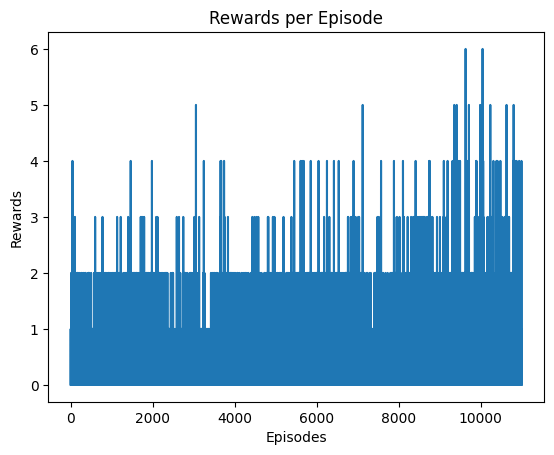

Episode 11010: Total Reward: 0.0, Epsilon: 0.6634810000110793, frames_done: 373910
Episode 11020: Total Reward: 0.0, Epsilon: 0.6630337000110941, frames_done: 374407
Episode 11030: Total Reward: 1.0, Epsilon: 0.6625684000111094, frames_done: 374924
Episode 11040: Total Reward: 0.0, Epsilon: 0.6621337000111237, frames_done: 375407
Episode 11050: Total Reward: 0.0, Epsilon: 0.6617485000111364, frames_done: 375835
Episode 11060: Total Reward: 0.0, Epsilon: 0.6615001000111446, frames_done: 376111
Episode 11070: Total Reward: 0.0, Epsilon: 0.6610429000111596, frames_done: 376619
Episode 11080: Total Reward: 0.0, Epsilon: 0.6606577000111723, frames_done: 377047
Episode 11090: Total Reward: 0.0, Epsilon: 0.6602077000111871, frames_done: 377547
Episode 11100: Total Reward: 0.0, Epsilon: 0.6598657000111984, frames_done: 377927
Episode 11110: Total Reward: 0.0, Epsilon: 0.6594778000112111, frames_done: 378358
Episode 11120: Total Reward: 0.0, Epsilon: 0.6591502000112219, frames_done: 378722
Epis

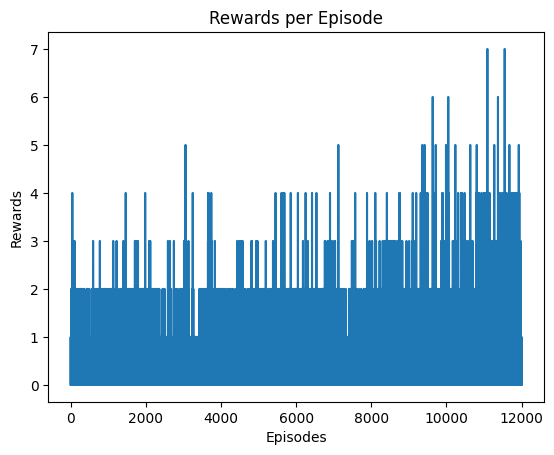

Episode 12010: Total Reward: 0.0, Epsilon: 0.6253759000123339, frames_done: 416249
Episode 12020: Total Reward: 1.0, Epsilon: 0.6247990000123529, frames_done: 416890
Episode 12030: Total Reward: 0.0, Epsilon: 0.6244651000123639, frames_done: 417261
Episode 12040: Total Reward: 0.0, Epsilon: 0.6241537000123741, frames_done: 417607
Episode 12050: Total Reward: 0.0, Epsilon: 0.6237091000123888, frames_done: 418101
Episode 12060: Total Reward: 0.0, Epsilon: 0.6234364000123978, frames_done: 418404
Episode 12070: Total Reward: 0.0, Epsilon: 0.6231448000124074, frames_done: 418728
Episode 12080: Total Reward: 0.0, Epsilon: 0.6227884000124191, frames_done: 419124
Episode 12090: Total Reward: 0.0, Epsilon: 0.6225328000124275, frames_done: 419408
Episode 12100: Total Reward: 0.0, Epsilon: 0.6220720000124427, frames_done: 419920
Episode 12110: Total Reward: 0.0, Epsilon: 0.621759700012453, frames_done: 420267
Episode 12120: Total Reward: 1.0, Epsilon: 0.6210388000124767, frames_done: 421068
Episo

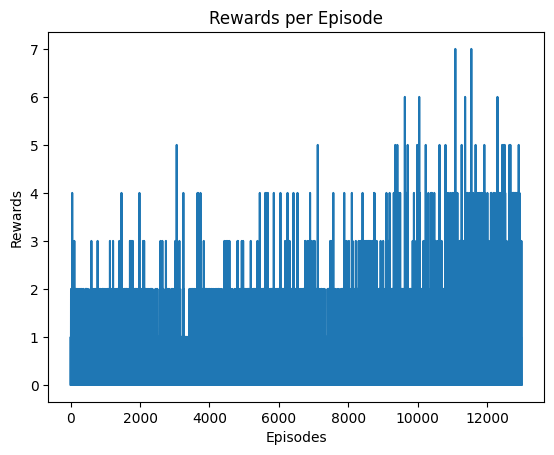

Episode 13010: Total Reward: 0.0, Epsilon: 0.5821255000137578, frames_done: 464305
Episode 13020: Total Reward: 0.0, Epsilon: 0.5817601000137699, frames_done: 464711
Episode 13030: Total Reward: 2.0, Epsilon: 0.581211100013788, frames_done: 465321
Episode 13040: Total Reward: 0.0, Epsilon: 0.5808772000137989, frames_done: 465692
Episode 13050: Total Reward: 1.0, Epsilon: 0.5805631000138093, frames_done: 466041
Episode 13060: Total Reward: 0.0, Epsilon: 0.5801617000138225, frames_done: 466487
Episode 13070: Total Reward: 0.0, Epsilon: 0.579843100013833, frames_done: 466841
Episode 13080: Total Reward: 0.0, Epsilon: 0.5792509000138525, frames_done: 467499
Episode 13090: Total Reward: 0.0, Epsilon: 0.578629000013873, frames_done: 468190
Episode 13100: Total Reward: 0.0, Epsilon: 0.5780998000138904, frames_done: 468778
Episode 13110: Total Reward: 0.0, Epsilon: 0.5773906000139137, frames_done: 469566
Episode 13120: Total Reward: 0.0, Epsilon: 0.5767075000139362, frames_done: 470325
Episode

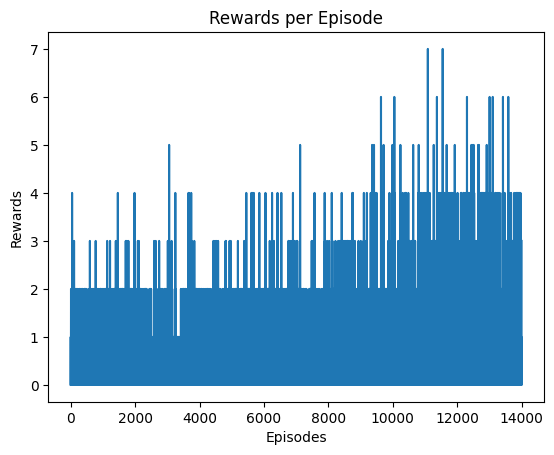

Episode 14010: Total Reward: 0.0, Epsilon: 0.5416588000150901, frames_done: 509268
Episode 14020: Total Reward: 0.0, Epsilon: 0.5413447000151005, frames_done: 509617
Episode 14030: Total Reward: 0.0, Epsilon: 0.5410477000151103, frames_done: 509947
Episode 14040: Total Reward: 1.0, Epsilon: 0.5405797000151257, frames_done: 510467
Episode 14050: Total Reward: 0.0, Epsilon: 0.5402539000151364, frames_done: 510829
Episode 14060: Total Reward: 0.0, Epsilon: 0.5398507000151497, frames_done: 511277
Episode 14070: Total Reward: 0.0, Epsilon: 0.5394403000151632, frames_done: 511733
Episode 14080: Total Reward: 0.0, Epsilon: 0.539051500015176, frames_done: 512165
Episode 14090: Total Reward: 0.0, Epsilon: 0.5385997000151909, frames_done: 512667
Episode 14100: Total Reward: 0.0, Epsilon: 0.5383927000151977, frames_done: 512897
Episode 14110: Total Reward: 0.0, Epsilon: 0.5380363000152094, frames_done: 513293
Episode 14120: Total Reward: 3.0, Epsilon: 0.5375350000152259, frames_done: 513850
Episo

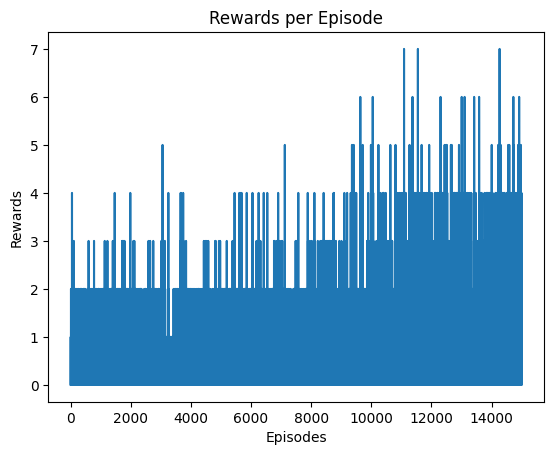

Episode 15010: Total Reward: 3.0, Epsilon: 0.4946743000163085, frames_done: 561473
Episode 15020: Total Reward: 0.0, Epsilon: 0.49422970001629574, frames_done: 561967
Episode 15030: Total Reward: 1.0, Epsilon: 0.49339180001627164, frames_done: 562898
Episode 15040: Total Reward: 0.0, Epsilon: 0.4924864000162456, frames_done: 563904
Episode 15050: Total Reward: 1.0, Epsilon: 0.49187530001622803, frames_done: 564583
Episode 15060: Total Reward: 0.0, Epsilon: 0.49150450001621737, frames_done: 564995
Episode 15070: Total Reward: 0.0, Epsilon: 0.4908997000162, frames_done: 565667
Episode 15080: Total Reward: 0.0, Epsilon: 0.49047490001618776, frames_done: 566139
Episode 15090: Total Reward: 0.0, Epsilon: 0.48961180001616295, frames_done: 567098
Episode 15100: Total Reward: 4.0, Epsilon: 0.48890260001614255, frames_done: 567886
Episode 15110: Total Reward: 1.0, Epsilon: 0.48815470001612105, frames_done: 568717
Episode 15120: Total Reward: 4.0, Epsilon: 0.48753280001610316, frames_done: 56940

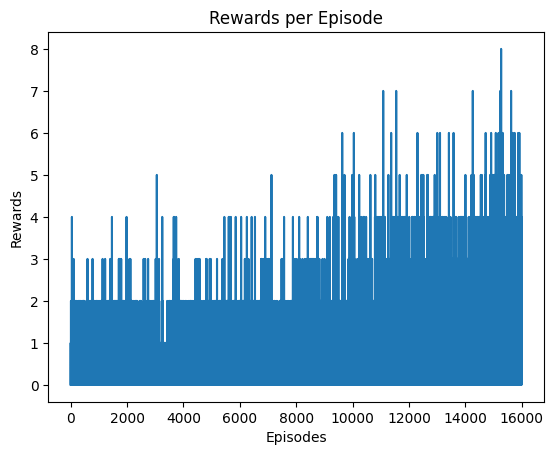

Episode 16010: Total Reward: 2.0, Epsilon: 0.43146730001449096, frames_done: 631703
Episode 16020: Total Reward: 1.0, Epsilon: 0.4307527000144704, frames_done: 632497
Episode 16030: Total Reward: 0.0, Epsilon: 0.43022260001445517, frames_done: 633086
Episode 16040: Total Reward: 0.0, Epsilon: 0.42980410001444314, frames_done: 633551
Episode 16050: Total Reward: 1.0, Epsilon: 0.4290751000144222, frames_done: 634361
Episode 16060: Total Reward: 1.0, Epsilon: 0.42842350001440344, frames_done: 635085
Episode 16070: Total Reward: 1.0, Epsilon: 0.4276396000143809, frames_done: 635956
Episode 16080: Total Reward: 0.0, Epsilon: 0.42705370001436405, frames_done: 636607
Episode 16090: Total Reward: 2.0, Epsilon: 0.4263643000143442, frames_done: 637373
Episode 16100: Total Reward: 2.0, Epsilon: 0.4258792000143303, frames_done: 637912
Episode 16110: Total Reward: 2.0, Epsilon: 0.4251358000143089, frames_done: 638738
Episode 16120: Total Reward: 4.0, Epsilon: 0.424617400014294, frames_done: 639314


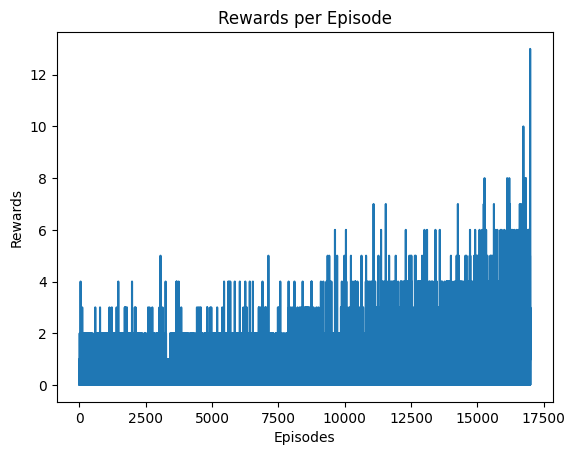

Episode 17010: Total Reward: 0.0, Epsilon: 0.35269570001222583, frames_done: 719227
Episode 17020: Total Reward: 2.0, Epsilon: 0.3519397000122041, frames_done: 720067
Episode 17030: Total Reward: 1.0, Epsilon: 0.351136900012181, frames_done: 720959
Episode 17040: Total Reward: 0.0, Epsilon: 0.3507643000121703, frames_done: 721373
Episode 17050: Total Reward: 5.0, Epsilon: 0.3498742000121447, frames_done: 722362
Episode 17060: Total Reward: 1.0, Epsilon: 0.34912810001212324, frames_done: 723191
Episode 17070: Total Reward: 0.0, Epsilon: 0.3481867000120962, frames_done: 724237
Episode 17080: Total Reward: 2.0, Epsilon: 0.34734430001207195, frames_done: 725173
Episode 17090: Total Reward: 1.0, Epsilon: 0.3466027000120506, frames_done: 725997
Episode 17100: Total Reward: 6.0, Epsilon: 0.34569910001202464, frames_done: 727001
Episode 17110: Total Reward: 2.0, Epsilon: 0.3449845000120041, frames_done: 727795
Episode 17120: Total Reward: 4.0, Epsilon: 0.3441889000119812, frames_done: 728679
E

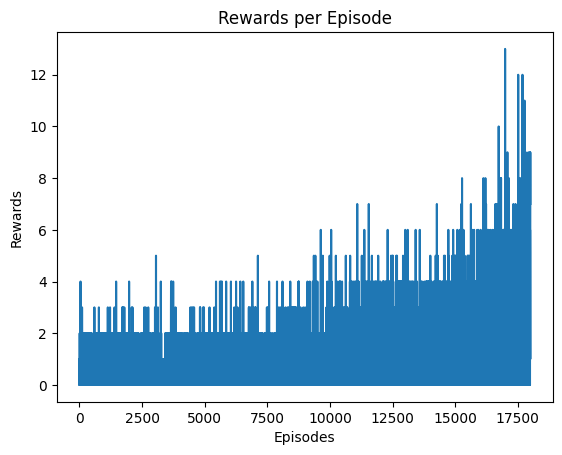

Episode 18010: Total Reward: 2.0, Epsilon: 0.2655055000097186, frames_done: 816105
Episode 18020: Total Reward: 5.0, Epsilon: 0.2644930000096895, frames_done: 817230
Episode 18030: Total Reward: 0.0, Epsilon: 0.2635579000096626, frames_done: 818269
Episode 18040: Total Reward: 3.0, Epsilon: 0.2626921000096377, frames_done: 819231
Episode 18050: Total Reward: 0.0, Epsilon: 0.26186860000961404, frames_done: 820146
Episode 18060: Total Reward: 1.0, Epsilon: 0.26121250000959517, frames_done: 820875
Episode 18070: Total Reward: 0.0, Epsilon: 0.2604097000095721, frames_done: 821767
Episode 18080: Total Reward: 0.0, Epsilon: 0.2595970000095487, frames_done: 822670
Episode 18090: Total Reward: 0.0, Epsilon: 0.25887070000952783, frames_done: 823477
Episode 18100: Total Reward: 2.0, Epsilon: 0.257625100009492, frames_done: 824861
Episode 18110: Total Reward: 1.0, Epsilon: 0.2567944000094681, frames_done: 825784
Episode 18120: Total Reward: 4.0, Epsilon: 0.2557216000094373, frames_done: 826976
Ep

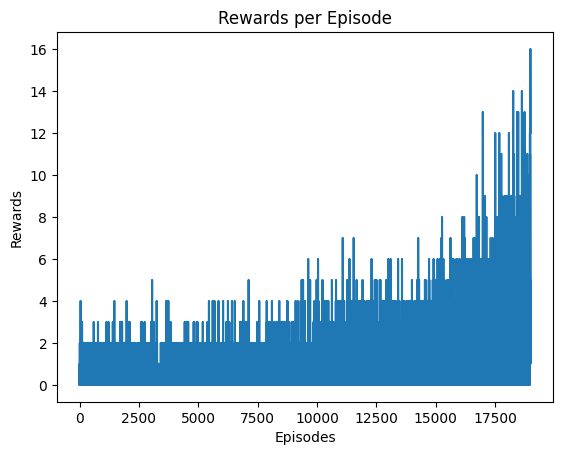

Episode 19010: Total Reward: 2.0, Epsilon: 0.15806350000946434, frames_done: 935485
Episode 19020: Total Reward: 4.0, Epsilon: 0.15609520000946844, frames_done: 937672
Episode 19030: Total Reward: 11.0, Epsilon: 0.15420520000947238, frames_done: 939772
Episode 19040: Total Reward: 3.0, Epsilon: 0.15311620000947465, frames_done: 940982
Episode 19050: Total Reward: 3.0, Epsilon: 0.1520335000094769, frames_done: 942185
Episode 19060: Total Reward: 4.0, Epsilon: 0.15071500000947965, frames_done: 943650
Episode 19070: Total Reward: 1.0, Epsilon: 0.14914720000948292, frames_done: 945392
Episode 19080: Total Reward: 2.0, Epsilon: 0.14783950000948565, frames_done: 946845
Episode 19090: Total Reward: 4.0, Epsilon: 0.14648590000948847, frames_done: 948349
Episode 19100: Total Reward: 2.0, Epsilon: 0.1452250000094911, frames_done: 949750
Episode 19110: Total Reward: 1.0, Epsilon: 0.1436329000094944, frames_done: 951519
Episode 19120: Total Reward: 10.0, Epsilon: 0.14236300000949706, frames_done: 

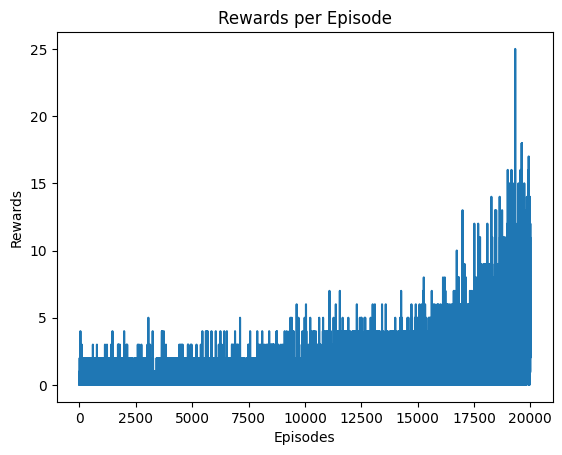

Episode 20010: Total Reward: 8.0, Epsilon: 0.1, frames_done: 1110938
Episode 20020: Total Reward: 5.0, Epsilon: 0.1, frames_done: 1112709
Episode 20030: Total Reward: 9.0, Epsilon: 0.1, frames_done: 1115033
Episode 20040: Total Reward: 1.0, Epsilon: 0.1, frames_done: 1117215
Episode 20050: Total Reward: 5.0, Epsilon: 0.1, frames_done: 1118943
Episode 20060: Total Reward: 7.0, Epsilon: 0.1, frames_done: 1120468
Episode 20070: Total Reward: 12.0, Epsilon: 0.1, frames_done: 1123331
Episode 20080: Total Reward: 1.0, Epsilon: 0.1, frames_done: 1124537
Episode 20090: Total Reward: 4.0, Epsilon: 0.1, frames_done: 1126017
Episode 20100: Total Reward: 0.0, Epsilon: 0.1, frames_done: 1127692
Episode 20110: Total Reward: 10.0, Epsilon: 0.1, frames_done: 1129449
Episode 20120: Total Reward: 10.0, Epsilon: 0.1, frames_done: 1131464
Episode 20130: Total Reward: 5.0, Epsilon: 0.1, frames_done: 1132718
Episode 20140: Total Reward: 0.0, Epsilon: 0.1, frames_done: 1134011
Episode 20150: Total Reward: 9.

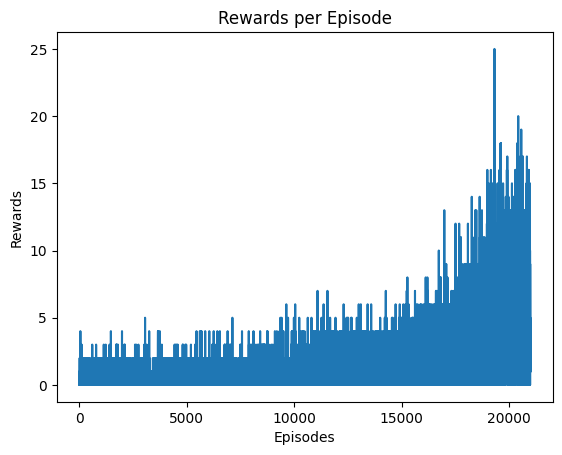

Episode 21010: Total Reward: 4.0, Epsilon: 0.1, frames_done: 1299602
Episode 21020: Total Reward: 7.0, Epsilon: 0.1, frames_done: 1301375
Episode 21030: Total Reward: 5.0, Epsilon: 0.1, frames_done: 1303119
Episode 21040: Total Reward: 6.0, Epsilon: 0.1, frames_done: 1305130
Episode 21050: Total Reward: 2.0, Epsilon: 0.1, frames_done: 1306524
Episode 21060: Total Reward: 17.0, Epsilon: 0.1, frames_done: 1308614
Episode 21070: Total Reward: 1.0, Epsilon: 0.1, frames_done: 1310455
Episode 21080: Total Reward: 0.0, Epsilon: 0.1, frames_done: 1312501
Episode 21090: Total Reward: 6.0, Epsilon: 0.1, frames_done: 1314831
Episode 21100: Total Reward: 5.0, Epsilon: 0.1, frames_done: 1316781
Episode 21110: Total Reward: 1.0, Epsilon: 0.1, frames_done: 1318756
Episode 21120: Total Reward: 4.0, Epsilon: 0.1, frames_done: 1320675
Episode 21130: Total Reward: 10.0, Epsilon: 0.1, frames_done: 1322401
Episode 21140: Total Reward: 5.0, Epsilon: 0.1, frames_done: 1325012
Episode 21150: Total Reward: 1.0

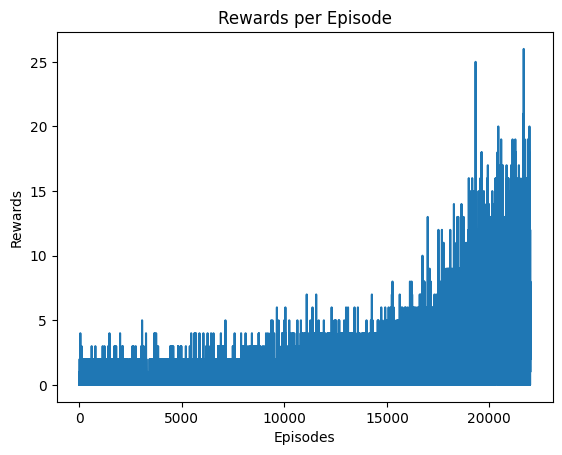

Episode 22010: Total Reward: 9.0, Epsilon: 0.1, frames_done: 1505626
Episode 22020: Total Reward: 1.0, Epsilon: 0.1, frames_done: 1507750
Episode 22030: Total Reward: 14.0, Epsilon: 0.1, frames_done: 1510367
Episode 22040: Total Reward: 30.0, Epsilon: 0.1, frames_done: 1513389
Episode 22050: Total Reward: 19.0, Epsilon: 0.1, frames_done: 1515887
Episode 22060: Total Reward: 1.0, Epsilon: 0.1, frames_done: 1517420
Episode 22070: Total Reward: 6.0, Epsilon: 0.1, frames_done: 1519421
Episode 22080: Total Reward: 3.0, Epsilon: 0.1, frames_done: 1521527
Episode 22090: Total Reward: 2.0, Epsilon: 0.1, frames_done: 1523570
Episode 22100: Total Reward: 8.0, Epsilon: 0.1, frames_done: 1525470
Episode 22110: Total Reward: 6.0, Epsilon: 0.1, frames_done: 1527825
Episode 22120: Total Reward: 6.0, Epsilon: 0.1, frames_done: 1530308
Episode 22130: Total Reward: 5.0, Epsilon: 0.1, frames_done: 1532508
Episode 22140: Total Reward: 7.0, Epsilon: 0.1, frames_done: 1534686
Episode 22150: Total Reward: 6.

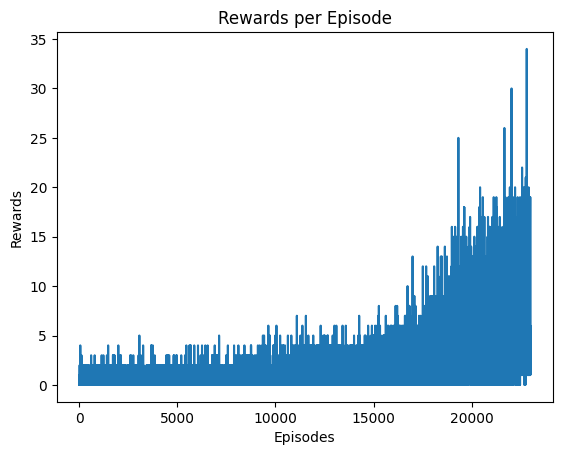

Episode 23010: Total Reward: 4.0, Epsilon: 0.1, frames_done: 1718342
Episode 23020: Total Reward: 5.0, Epsilon: 0.1, frames_done: 1721059
Episode 23030: Total Reward: 0.0, Epsilon: 0.1, frames_done: 1723703
Episode 23040: Total Reward: 18.0, Epsilon: 0.1, frames_done: 1726171
Episode 23050: Total Reward: 17.0, Epsilon: 0.1, frames_done: 1729209
Episode 23060: Total Reward: 6.0, Epsilon: 0.1, frames_done: 1730699
Episode 23070: Total Reward: 4.0, Epsilon: 0.1, frames_done: 1732473
Episode 23080: Total Reward: 15.0, Epsilon: 0.1, frames_done: 1735208
Episode 23090: Total Reward: 14.0, Epsilon: 0.1, frames_done: 1737430
Episode 23100: Total Reward: 9.0, Epsilon: 0.1, frames_done: 1739519
Episode 23110: Total Reward: 2.0, Epsilon: 0.1, frames_done: 1741195
Episode 23120: Total Reward: 6.0, Epsilon: 0.1, frames_done: 1743809
Episode 23130: Total Reward: 4.0, Epsilon: 0.1, frames_done: 1745757
Episode 23140: Total Reward: 20.0, Epsilon: 0.1, frames_done: 1748299
Episode 23150: Total Reward: 

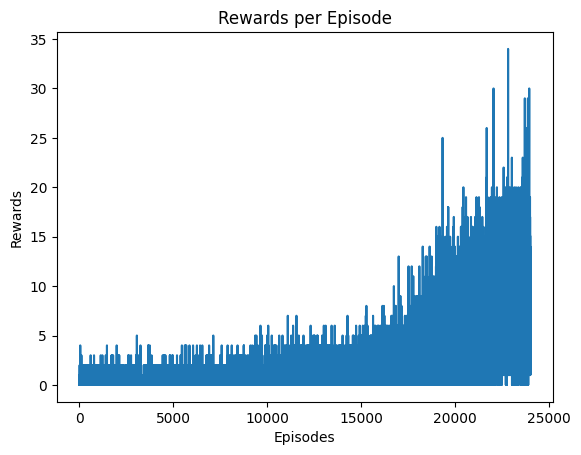

Episode 24010: Total Reward: 3.0, Epsilon: 0.1, frames_done: 1942715
Episode 24020: Total Reward: 4.0, Epsilon: 0.1, frames_done: 1944965
Episode 24030: Total Reward: 25.0, Epsilon: 0.1, frames_done: 1947269
Episode 24040: Total Reward: 3.0, Epsilon: 0.1, frames_done: 1949186
Episode 24050: Total Reward: 4.0, Epsilon: 0.1, frames_done: 1951440
Episode 24060: Total Reward: 1.0, Epsilon: 0.1, frames_done: 1953379
Episode 24070: Total Reward: 1.0, Epsilon: 0.1, frames_done: 1955244
Episode 24080: Total Reward: 6.0, Epsilon: 0.1, frames_done: 1957444
Episode 24090: Total Reward: 1.0, Epsilon: 0.1, frames_done: 1959261
Episode 24100: Total Reward: 4.0, Epsilon: 0.1, frames_done: 1961729
Episode 24110: Total Reward: 16.0, Epsilon: 0.1, frames_done: 1963958
Episode 24120: Total Reward: 1.0, Epsilon: 0.1, frames_done: 1966278
Episode 24130: Total Reward: 7.0, Epsilon: 0.1, frames_done: 1968036
Episode 24140: Total Reward: 6.0, Epsilon: 0.1, frames_done: 1970439
Episode 24150: Total Reward: 15.

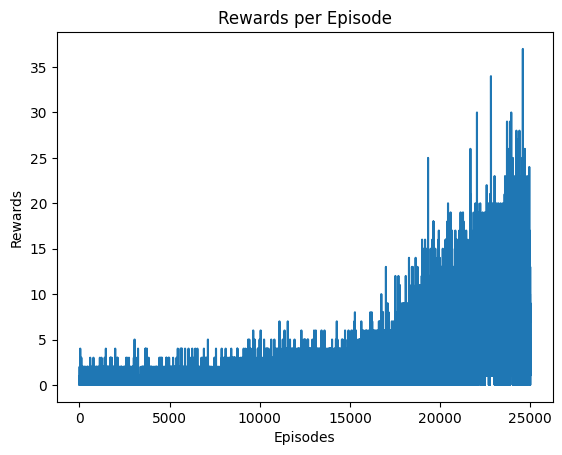

Episode 25010: Total Reward: 11.0, Epsilon: 0.1, frames_done: 2160344
Episode 25020: Total Reward: 5.0, Epsilon: 0.1, frames_done: 2162570
Episode 25030: Total Reward: 9.0, Epsilon: 0.1, frames_done: 2164946
Episode 25040: Total Reward: 6.0, Epsilon: 0.1, frames_done: 2167376
Episode 25050: Total Reward: 6.0, Epsilon: 0.1, frames_done: 2170158
Episode 25060: Total Reward: 12.0, Epsilon: 0.1, frames_done: 2172560
Episode 25070: Total Reward: 28.0, Epsilon: 0.1, frames_done: 2175548
Episode 25080: Total Reward: 11.0, Epsilon: 0.1, frames_done: 2178025
Episode 25090: Total Reward: 3.0, Epsilon: 0.1, frames_done: 2179732
Episode 25100: Total Reward: 1.0, Epsilon: 0.1, frames_done: 2181933
Episode 25110: Total Reward: 4.0, Epsilon: 0.1, frames_done: 2184360
Episode 25120: Total Reward: 10.0, Epsilon: 0.1, frames_done: 2186310
Episode 25130: Total Reward: 6.0, Epsilon: 0.1, frames_done: 2188365
Episode 25140: Total Reward: 5.0, Epsilon: 0.1, frames_done: 2190596
Episode 25150: Total Reward: 

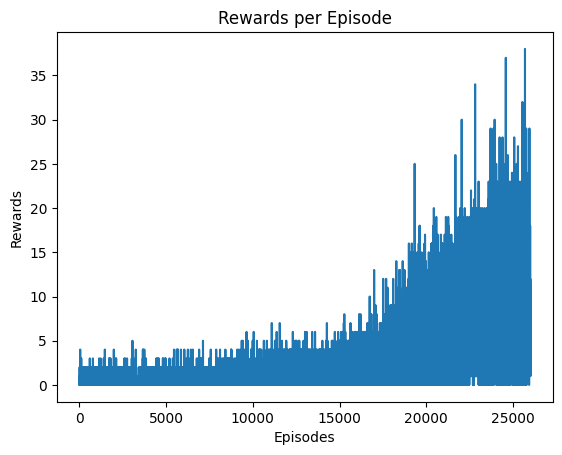

Episode 26010: Total Reward: 4.0, Epsilon: 0.1, frames_done: 2385974
Episode 26020: Total Reward: 6.0, Epsilon: 0.1, frames_done: 2388545
Episode 26030: Total Reward: 17.0, Epsilon: 0.1, frames_done: 2390970
Episode 26040: Total Reward: 4.0, Epsilon: 0.1, frames_done: 2392887
Episode 26050: Total Reward: 5.0, Epsilon: 0.1, frames_done: 2394364
Episode 26060: Total Reward: 4.0, Epsilon: 0.1, frames_done: 2396630
Episode 26070: Total Reward: 4.0, Epsilon: 0.1, frames_done: 2398695
Episode 26080: Total Reward: 2.0, Epsilon: 0.1, frames_done: 2401005
Episode 26090: Total Reward: 6.0, Epsilon: 0.1, frames_done: 2403220
Episode 26100: Total Reward: 7.0, Epsilon: 0.1, frames_done: 2405371
Episode 26110: Total Reward: 4.0, Epsilon: 0.1, frames_done: 2408217
Episode 26120: Total Reward: 3.0, Epsilon: 0.1, frames_done: 2410268
Episode 26130: Total Reward: 9.0, Epsilon: 0.1, frames_done: 2412857
Episode 26140: Total Reward: 7.0, Epsilon: 0.1, frames_done: 2414766
Episode 26150: Total Reward: 3.0,

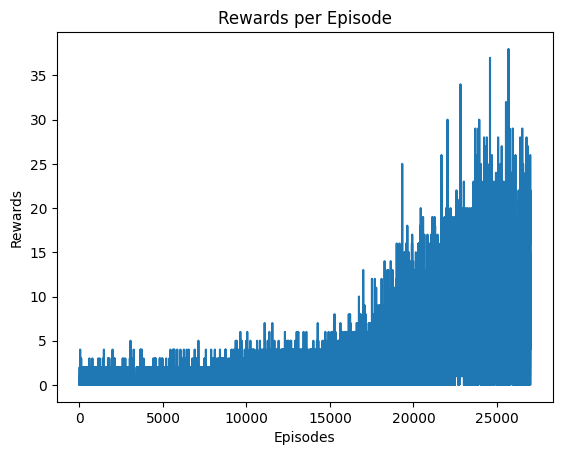

Episode 27010: Total Reward: 4.0, Epsilon: 0.1, frames_done: 2614499
Episode 27020: Total Reward: 8.0, Epsilon: 0.1, frames_done: 2616684
Episode 27030: Total Reward: 5.0, Epsilon: 0.1, frames_done: 2618228
Episode 27040: Total Reward: 8.0, Epsilon: 0.1, frames_done: 2620880
Episode 27050: Total Reward: 11.0, Epsilon: 0.1, frames_done: 2623138
Episode 27060: Total Reward: 14.0, Epsilon: 0.1, frames_done: 2626162
Episode 27070: Total Reward: 3.0, Epsilon: 0.1, frames_done: 2628725
Episode 27080: Total Reward: 1.0, Epsilon: 0.1, frames_done: 2631035
Episode 27090: Total Reward: 4.0, Epsilon: 0.1, frames_done: 2632947
Episode 27100: Total Reward: 14.0, Epsilon: 0.1, frames_done: 2635762
Episode 27110: Total Reward: 11.0, Epsilon: 0.1, frames_done: 2638450
Episode 27120: Total Reward: 5.0, Epsilon: 0.1, frames_done: 2640465
Episode 27130: Total Reward: 0.0, Epsilon: 0.1, frames_done: 2642453
Episode 27140: Total Reward: 6.0, Epsilon: 0.1, frames_done: 2645021
Episode 27150: Total Reward: 1

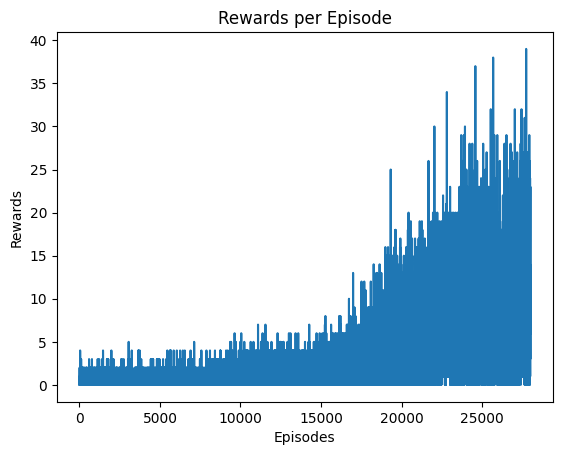

Episode 28010: Total Reward: 7.0, Epsilon: 0.1, frames_done: 2846017
Episode 28020: Total Reward: 3.0, Epsilon: 0.1, frames_done: 2848497
Episode 28030: Total Reward: 1.0, Epsilon: 0.1, frames_done: 2851174
Episode 28040: Total Reward: 5.0, Epsilon: 0.1, frames_done: 2853093
Episode 28050: Total Reward: 14.0, Epsilon: 0.1, frames_done: 2855709
Episode 28060: Total Reward: 2.0, Epsilon: 0.1, frames_done: 2857589
Episode 28070: Total Reward: 1.0, Epsilon: 0.1, frames_done: 2859488
Episode 28080: Total Reward: 7.0, Epsilon: 0.1, frames_done: 2862179
Episode 28090: Total Reward: 6.0, Epsilon: 0.1, frames_done: 2864180
Episode 28100: Total Reward: 8.0, Epsilon: 0.1, frames_done: 2866512
Episode 28110: Total Reward: 25.0, Epsilon: 0.1, frames_done: 2869379
Episode 28120: Total Reward: 12.0, Epsilon: 0.1, frames_done: 2871394
Episode 28130: Total Reward: 1.0, Epsilon: 0.1, frames_done: 2874205
Episode 28140: Total Reward: 11.0, Epsilon: 0.1, frames_done: 2876714
Episode 28150: Total Reward: 1

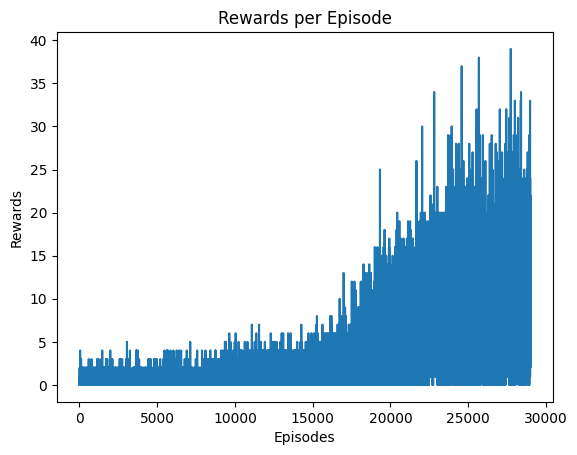

Episode 29010: Total Reward: 19.0, Epsilon: 0.1, frames_done: 3085389
Episode 29020: Total Reward: 11.0, Epsilon: 0.1, frames_done: 3088192
Episode 29030: Total Reward: 14.0, Epsilon: 0.1, frames_done: 3091031
Episode 29040: Total Reward: 4.0, Epsilon: 0.1, frames_done: 3092803
Episode 29050: Total Reward: 4.0, Epsilon: 0.1, frames_done: 3094952
Episode 29060: Total Reward: 1.0, Epsilon: 0.1, frames_done: 3096555
Episode 29070: Total Reward: 3.0, Epsilon: 0.1, frames_done: 3098938
Episode 29080: Total Reward: 5.0, Epsilon: 0.1, frames_done: 3101352
Episode 29090: Total Reward: 9.0, Epsilon: 0.1, frames_done: 3103341
Episode 29100: Total Reward: 6.0, Epsilon: 0.1, frames_done: 3105021
Episode 29110: Total Reward: 6.0, Epsilon: 0.1, frames_done: 3107066
Episode 29120: Total Reward: 4.0, Epsilon: 0.1, frames_done: 3109738
Episode 29130: Total Reward: 12.0, Epsilon: 0.1, frames_done: 3112293
Episode 29140: Total Reward: 2.0, Epsilon: 0.1, frames_done: 3114698
Episode 29150: Total Reward: 4

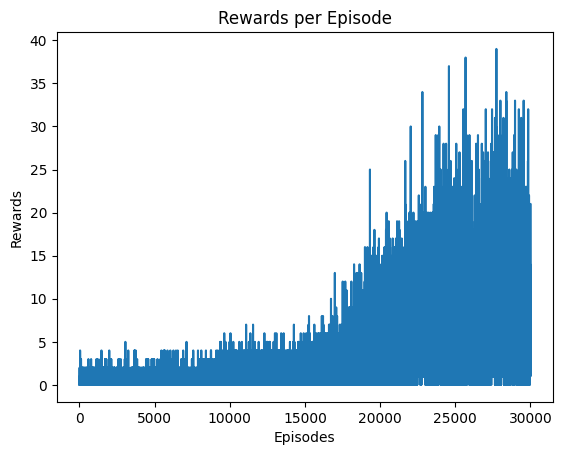

Episode 30010: Total Reward: 0.0, Epsilon: 0.1, frames_done: 3314087
Episode 30020: Total Reward: 4.0, Epsilon: 0.1, frames_done: 3315779
Episode 30030: Total Reward: 26.0, Epsilon: 0.1, frames_done: 3318956
Episode 30040: Total Reward: 13.0, Epsilon: 0.1, frames_done: 3320907
Episode 30050: Total Reward: 18.0, Epsilon: 0.1, frames_done: 3323161
Episode 30060: Total Reward: 4.0, Epsilon: 0.1, frames_done: 3325562
Episode 30070: Total Reward: 9.0, Epsilon: 0.1, frames_done: 3327904
Episode 30080: Total Reward: 2.0, Epsilon: 0.1, frames_done: 3330272
Episode 30090: Total Reward: 3.0, Epsilon: 0.1, frames_done: 3332128
Episode 30100: Total Reward: 13.0, Epsilon: 0.1, frames_done: 3334212
Episode 30110: Total Reward: 15.0, Epsilon: 0.1, frames_done: 3336682
Episode 30120: Total Reward: 3.0, Epsilon: 0.1, frames_done: 3338964
Episode 30130: Total Reward: 3.0, Epsilon: 0.1, frames_done: 3341471
Episode 30140: Total Reward: 5.0, Epsilon: 0.1, frames_done: 3344253
Episode 30150: Total Reward: 

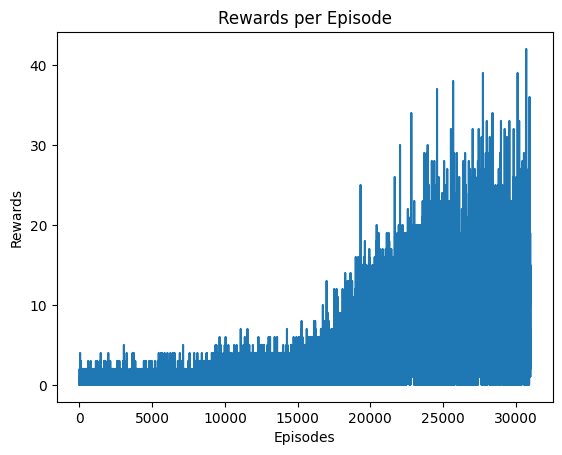

Episode 31010: Total Reward: 6.0, Epsilon: 0.1, frames_done: 3550091
Episode 31020: Total Reward: 8.0, Epsilon: 0.1, frames_done: 3552212
Episode 31030: Total Reward: 11.0, Epsilon: 0.1, frames_done: 3553941
Episode 31040: Total Reward: 15.0, Epsilon: 0.1, frames_done: 3555638
Episode 31050: Total Reward: 5.0, Epsilon: 0.1, frames_done: 3558088
Episode 31060: Total Reward: 16.0, Epsilon: 0.1, frames_done: 3560791
Episode 31070: Total Reward: 19.0, Epsilon: 0.1, frames_done: 3563425
Episode 31080: Total Reward: 20.0, Epsilon: 0.1, frames_done: 3566201
Episode 31090: Total Reward: 4.0, Epsilon: 0.1, frames_done: 3568445
Episode 31100: Total Reward: 22.0, Epsilon: 0.1, frames_done: 3571951
Episode 31110: Total Reward: 1.0, Epsilon: 0.1, frames_done: 3573765
Episode 31120: Total Reward: 12.0, Epsilon: 0.1, frames_done: 3575790
Episode 31130: Total Reward: 23.0, Epsilon: 0.1, frames_done: 3578306
Episode 31140: Total Reward: 5.0, Epsilon: 0.1, frames_done: 3580560
Episode 31150: Total Rewar

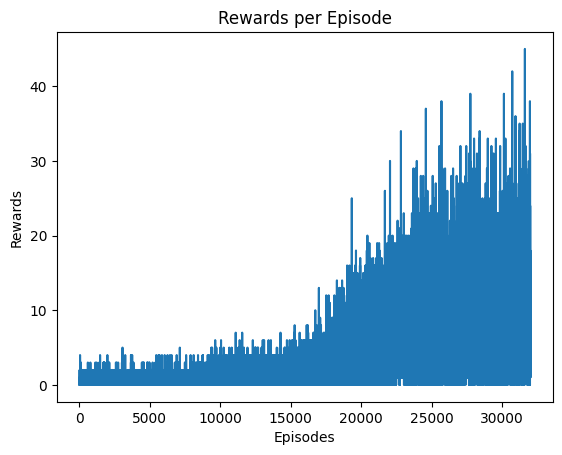

Episode 32010: Total Reward: 3.0, Epsilon: 0.1, frames_done: 3800553
Episode 32020: Total Reward: 15.0, Epsilon: 0.1, frames_done: 3803152
Episode 32030: Total Reward: 2.0, Epsilon: 0.1, frames_done: 3805295
Episode 32040: Total Reward: 10.0, Epsilon: 0.1, frames_done: 3807897
Episode 32050: Total Reward: 1.0, Epsilon: 0.1, frames_done: 3810150
Episode 32060: Total Reward: 15.0, Epsilon: 0.1, frames_done: 3813436
Episode 32070: Total Reward: 7.0, Epsilon: 0.1, frames_done: 3814865
Episode 32080: Total Reward: 6.0, Epsilon: 0.1, frames_done: 3816988
Episode 32090: Total Reward: 11.0, Epsilon: 0.1, frames_done: 3819246
Episode 32100: Total Reward: 14.0, Epsilon: 0.1, frames_done: 3822305
Episode 32110: Total Reward: 11.0, Epsilon: 0.1, frames_done: 3825051
Episode 32120: Total Reward: 12.0, Epsilon: 0.1, frames_done: 3828161
Episode 32130: Total Reward: 14.0, Epsilon: 0.1, frames_done: 3830763
Episode 32140: Total Reward: 8.0, Epsilon: 0.1, frames_done: 3833446
Episode 32150: Total Rewar

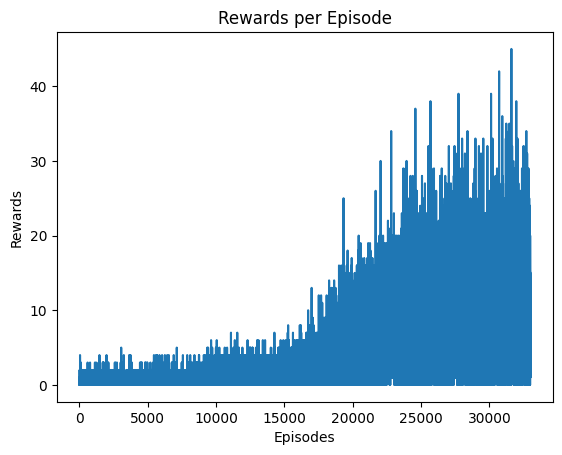

Episode 33010: Total Reward: 4.0, Epsilon: 0.1, frames_done: 4048176
Episode 33020: Total Reward: 8.0, Epsilon: 0.1, frames_done: 4049807
Episode 33030: Total Reward: 2.0, Epsilon: 0.1, frames_done: 4052601
Episode 33040: Total Reward: 4.0, Epsilon: 0.1, frames_done: 4054819
Episode 33050: Total Reward: 9.0, Epsilon: 0.1, frames_done: 4057949
Episode 33060: Total Reward: 8.0, Epsilon: 0.1, frames_done: 4060354
Episode 33070: Total Reward: 12.0, Epsilon: 0.1, frames_done: 4062779
Episode 33080: Total Reward: 10.0, Epsilon: 0.1, frames_done: 4065067
Episode 33090: Total Reward: 2.0, Epsilon: 0.1, frames_done: 4067492
Episode 33100: Total Reward: 7.0, Epsilon: 0.1, frames_done: 4070097
Episode 33110: Total Reward: 10.0, Epsilon: 0.1, frames_done: 4072404
Episode 33120: Total Reward: 20.0, Epsilon: 0.1, frames_done: 4075518
Episode 33130: Total Reward: 6.0, Epsilon: 0.1, frames_done: 4078125
Episode 33140: Total Reward: 19.0, Epsilon: 0.1, frames_done: 4081510
Episode 33150: Total Reward: 

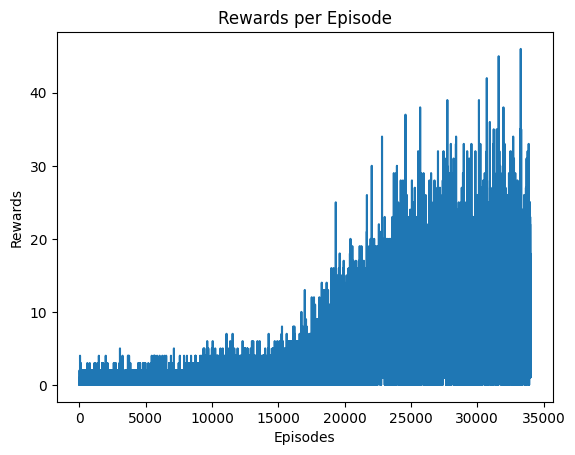

Episode 34010: Total Reward: 5.0, Epsilon: 0.1, frames_done: 4299816
Episode 34020: Total Reward: 4.0, Epsilon: 0.1, frames_done: 4301663
Episode 34030: Total Reward: 12.0, Epsilon: 0.1, frames_done: 4305030
Episode 34040: Total Reward: 23.0, Epsilon: 0.1, frames_done: 4307265
Episode 34050: Total Reward: 10.0, Epsilon: 0.1, frames_done: 4309479
Episode 34060: Total Reward: 12.0, Epsilon: 0.1, frames_done: 4312051
Episode 34070: Total Reward: 7.0, Epsilon: 0.1, frames_done: 4314720
Episode 34080: Total Reward: 14.0, Epsilon: 0.1, frames_done: 4317370
Episode 34090: Total Reward: 0.0, Epsilon: 0.1, frames_done: 4319449
Episode 34100: Total Reward: 5.0, Epsilon: 0.1, frames_done: 4321459
Episode 34110: Total Reward: 7.0, Epsilon: 0.1, frames_done: 4324027
Episode 34120: Total Reward: 20.0, Epsilon: 0.1, frames_done: 4327035
Episode 34130: Total Reward: 7.0, Epsilon: 0.1, frames_done: 4329020
Episode 34140: Total Reward: 3.0, Epsilon: 0.1, frames_done: 4331678
Episode 34150: Total Reward:

In [ ]:
# function for plotting rewards and saving agent and networks each X episodes.
def plot_rewards_save(agent, episode):
    plt.plot(agent.episode_rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title("Rewards per Episode")
    plt.show()
    torch.save(agent.policy_net.state_dict(), os.path.join("/content/drive/MyDrive/Colab/", f"policy_net_{episode}"))
    torch.save(agent.target_net.state_dict(), os.path.join("/content/drive/MyDrive/Colab/", f"target_net_{episode}"))
    # torch.save(agent.state_dict(), os.path.join("/content/drive/MyDrive/Colab/", f"agent_{episode}"))


def train(agent, env, num_episodes=35000, num_steps=10000):
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        for t in range(num_steps):
            agent.steps_done += 1
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.store_transition(state, action, reward, next_state, done)

            agent.epsilon = max(agent.epsilon - EPSILON_DECAY, agent.epsilon_min) #updating epsilon

            state = next_state
            total_reward += reward

            if agent.steps_done % 4 == 0:
                agent.optimize_model()

            if agent.steps_done % TARGET_UPDATE == 0:
                agent.update_target_net()
            if done:
                break
        agent.episode_rewards.append(total_reward)


        if episode % 10 == 0: #printing rewards each 10 episodes
            print(f"Episode {episode}: Total Reward: {total_reward}, Epsilon: {agent.epsilon}, frames_done: {agent.steps_done}")

        if episode % 1000 == 0 and episode!= 0:
            plot_rewards_save(agent, episode)

        agent.average_rewards = np.mean(agent.episode_rewards)


        # Achieving a mean reward above 50 in the Atari Breakout environment is quite good.
        # It suggests that the agent is performing well, so we can stop the training.
        if agent.average_rewards > 50:
            print(f"Solved at episode {episode}!")
            break

# Initialize environment and agent
env = make_env()
agent = DQNAgent(env.observation_space.shape, env.action_space.n)

# Train the agent
train(agent, env)


In [ ]:
torch.save(agent, os.path.join("/content/drive/MyDrive/Colab/", f"agent_{34000}"))

##Rewards Graph for the last saved trained model - 34000 episodes

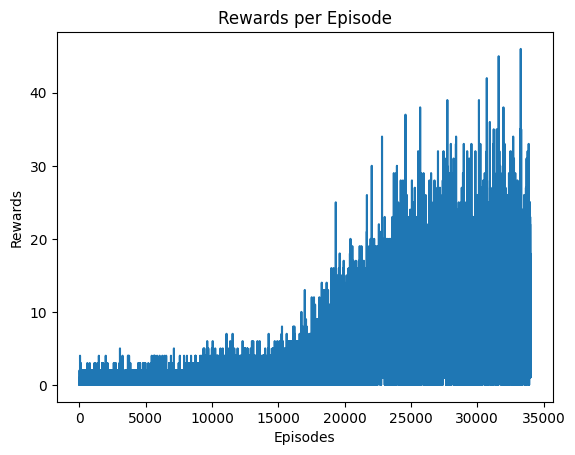

In [ ]:
# run sessions
import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

ENV_NAME = "BreakoutNoFrameskip-v4"

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env_test = make_env()
env_test.reset()
n_actions = env_test.action_space.n
state_shape = env_test.observation_space.shape
agent = DQNAgent(state_shape, n_actions)


# Show Video

In [ ]:
def evaluate_test(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []

    saved_network = DQN_Network(state_shape, n_actions)
    saved_network.load_state_dict(torch.load("/content/drive/MyDrive/Colab/policy_net_34000"))
    saved_network.eval()

    for _ in range(n_games):
        lives_counter = 0
        s = env.reset()
        reward = 0
        qvalues_list = []
        actions_list = []

        for _ in range(t_max):
            state_tensor = torch.FloatTensor([s])
            qvalues = saved_network(state_tensor).detach().numpy()
            qvalues_list.append(qvalues)
            action = qvalues.argmax(axis=-1).item()
            actions_list.append(action)

            s, r, done, _ = env.step(action)
            reward += r

            if done:
              env.reset()
              lives_counter += 1

            if lives_counter == 5:
              break

        rewards.append(reward)
    return np.mean(rewards)

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate_test(env_monitor, agent, n_games=1, greedy=False) ]

# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = max(video_paths, key=os.path.getctime)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))


<ipython-input-9-bca1147d354c>:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  state_tensor = torch.FloatTensor([s])
